In [18]:
using Random
using LinearAlgebra
using Statistics
using Plots
import Base.isless

using Cxx, Libdl

In [2]:
const path_to_lib = pwd()
addHeaderDir(path_to_lib*"/world/", kind=C_System)
cxxinclude("runWorld.h")

In [3]:
mutable struct Bird
    genes::Array{Float64}
    fitness::Float64
end

function Bird(;dim=5)
    genes = randn(dim)
    fitness = 0.0
    Bird(genes, fitness)
end 

function isless(b1::Bird, b2::Bird)
    b1.fitness < b2.fitness
end

isless (generic function with 45 methods)

In [5]:
#test
flappy = Bird()
println(flappy)

Bird([-1.2802602182852139, 1.4351352630982852, 0.5731429463997817, -0.5885766079519098, 0.8615936909104359], 0.0)


In [6]:
cxx"""

static double evaluate_bird(float g1, float g2, float g3, float g4, float g5) {
float ind[5] = {g1,g2,g3,g4,g5};

	const int NRUN = 3;
	auto &g = ind;
	double d = 0;
	for (int r = 0; r < NRUN; ++r) {
		World world;
		world.gen.seed(r * 100);
		while (world.bestiau.vivant) {

            world.update();
            // update inputs
            float birdY = world.bestiau.y;
            float birdVY = world.bestiau.vit;
            float obsX;
            float obsY;
            if (world.obstacles.size() > 0) {
                const auto &o = world.obstacles.front();
                obsY = o.y + world.hauteurPassage * 0.5;
                obsX = o.x / world.W;
            } else {
                obsY = world.H * 0.5;
                obsX = 1000.0;
            }
            double dd = world.dist;
            //if ((g[0]*birdY+g[1]*birdVY+g[2]*obsX+g[3]*obsY)>1.0) world.bestiauUp();
            //if ((g[0]*(birdY-obsY)+g[1]*birdY+g[2]*obsX+g[3]*birdVY)>1.0) world.bestiauUp();
            //if ((g[0]*(birdY-obsY)+g[1]*birdY+g[2]*obsX+g[3]*birdVY+g[4]*dd)>1.0) world.bestiauUp();
            if ((g[0]*(birdY-obsY)+g[1]*birdY+g[2]*obsX+g[3]*birdVY+g[4]*world.vitesseDefilement)>1.0) world.bestiauUp();
        }
        d += world.dist;
        d -= 0.001*abs(world.bestiau.y-world.obstacles.front().y);
    }
    return d;
}
"""

true

In [7]:
cpptojulia(g1::Float64, g2::Float64, g3::Float64, g4::Float64, g5::Float64) = @cxx evaluate_bird(g1,g2,g3,g4,g5)
function evaluate_bird(g::Array{Float64})
    cpptojulia(g[1],g[2],g[3],g[4],g[5])
end

evaluate_bird (generic function with 1 method)

In [8]:
function evaluate!(flappy::Bird)
    g=flappy.genes
    flappy.fitness = evaluate_bird(g)
end

evaluate! (generic function with 1 method)

In [9]:
# test

flappy = Bird()
println(flappy)
g = flappy.genes
ev = evaluate_bird(g)
println(ev)
evaluate!(flappy)
println(flappy)

println("_____2nd______")
flappy2 = Bird()
flappy2.genes = [-3.72, -0.46, -0.227, -1.90, 0.0] #param pour {deltaY, bY, oX, bVY} >1.0
println(flappy2)
ev2 = evaluate_bird(flappy2.genes)
println(ev2)
evaluate!(flappy2)
println(flappy2)


println("isless ", flappy>flappy2)
println("isless ", flappy<flappy2)



Bird([-0.02207010896074149, 0.5170846254149166, 0.8255347774377015, -1.4207768288326692, -0.28920378386097817], 0.0)
1.178584475393305
Bird([-0.02207010896074149, 0.5170846254149166, 0.8255347774377015, -1.4207768288326692, -0.28920378386097817], 1.178584475393305)
_____2nd______
Bird([-3.72, -0.46, -0.227, -1.9, 0.0], 0.0)
310.75271993426566
Bird([-3.72, -0.46, -0.227, -1.9, 0.0], 310.75271993426566)
isless false
isless true


In [10]:



#  _________________________ES 1____________________________




In [11]:
function step_birds(best::Array{Float64};dim=5, npop=50, sigma=0.1, alpha=sigma/10)
    N = randn(npop,dim)
    P = repeat(best, 1, npop)' .+  sigma.* N #[N[i,:].*sigma for i in 1:npop]

    R = zeros(npop)
    for i in eachindex(R)
        R[i] = objective(P[i, :]) #evaluation
    end
    
    
    #println("  R    :", R)
    
    A = (R .- mean(R)) ./ std(R)
    #println("____________________")
    #println(" A :", A)
    #println("____________________")
    #println(" N : ", N[:,1])
    
    test = dot(N[:, 1], A)
    #println(" test :", test)
    if isnan(test)
        println("failed")
    end
    mat = [dot(N[:, i], A) for i in 1:size(N, 2)]
    #println("mat : ", mat)
    #println(alpha/(npop * sigma) .* mat)
    w = alpha/(npop * sigma) .* mat#[dot(N[:, i], A) for i in 1:size(N, dim)]
    #println(" w : ", w)
    best = best .+ w #modification step: changing the center of gravity
    best
end

step_birds (generic function with 1 method)

In [81]:
function run_es_bird(;Nstep=500, Npop=100, Sigma=0.1)
    dim = 5
    #best = randn(dim)
    #best = [-4.991793690362872, -1.0548510731723693, -0.46613776158659587, -2.281903602732939, -0.0011843804167953435]
    best = [-3.7801608774814435, -0.3807797572729434, -0.1904445735415997, -2.0321882891336522, -0.067457035171137]
    
    println("best initial: ", best)
    first_fitness = evaluate_bird(best)
    println("best initial fitness:", first_fitness)
    
    dist = zeros(Nstep)
    for i in 1:Nstep
        best = step_birds(best, dim=dim, npop=Npop, sigma=Sigma)
        #println("best: ", best)
        #println("best norm: ", norm(best))
        #println("dist max :" , objective(best))
        dist[i] = objective(best)
        #if dist[i]>300
         #   Sigma = 0.01
        #end
    end
    println("best final: ", best)
    println("best final dist: ", objective(best))
    #best
    dist
end

run_es_bird (generic function with 1 method)

best initial: [1.9524587734737011, -0.05966219117210583, -0.728517690422775, -0.1321347110353562, -1.0855721723849872]
best initial fitness:1.052214059349051
best final: [1.9394037302590896, -0.11513120083527291, -0.7163539011270101, -0.12625827315995874, -1.0655983637080242]
best final dist: 1.052214059349051


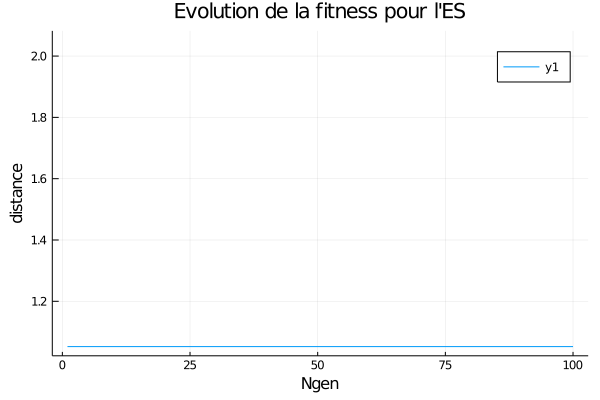

In [57]:
objective = evaluate_bird
Npop = 1000
Ngen = 100
sig = 0.1
res = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sig)
distances = res
plot(distances)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness pour l'ES")

best initial: [-3.7801608774814435, -0.3807797572729434, -0.1904445735415997, -2.0321882891336522, -0.067457035171137]
best initial fitness:358.579500125548
failed
best final: [NaN, NaN, NaN, NaN, NaN]
best final dist: 1.052214059349051
best initial: [-3.7801608774814435, -0.3807797572729434, -0.1904445735415997, -2.0321882891336522, -0.067457035171137]
best initial fitness:358.579500125548
failed
best final: [NaN, NaN, NaN, NaN, NaN]
best final dist: 1.052214059349051
best initial: [-3.7801608774814435, -0.3807797572729434, -0.1904445735415997, -2.0321882891336522, -0.067457035171137]
best initial fitness:358.579500125548
failed
best final: [NaN, NaN, NaN, NaN, NaN]
best final dist: 1.052214059349051
best initial: [-3.7801608774814435, -0.3807797572729434, -0.1904445735415997, -2.0321882891336522, -0.067457035171137]
best initial fitness:358.579500125548
best final: [-3.842455539073531, -0.07366909325953937, -0.05748064683387716, -1.9114440985766314, -0.0593217268045078]
best final di

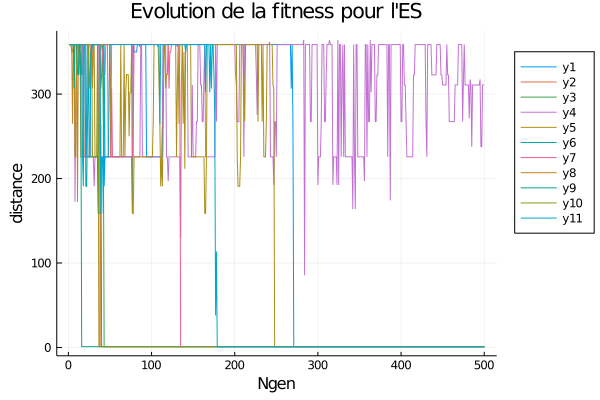

In [82]:
objective = evaluate_bird
Npop = 200
Ngen = 500
sig = 0.001
res = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sig)
distances = res
plot(distances,legend=:outertopright)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness pour l'ES")

for i in 1:10
    res = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sig)
    distances = res
    plot!(distances)
end

current()

#####avec Npop = 200, Ngen = 500, sig = 0.1
#best initial: [0.19507200551351175, -0.08498603878178577, 0.9501283764216036, 0.20293169509199305, 0.9760144556650499]
#best initial fitness:0.29995407539330476
#best final: [-3.7801608774814435, -0.3807797572729434, -0.1904445735415997, -2.0321882891336522, -0.067457035171137]
#best final dist: 358.579500125548

In [84]:



#  _________________________ES____________________________




In [85]:
mutable struct Obj_es
    center::Bird
    best::Array{Bird}
end

function Obj_es(;mu=5)
    center = Bird()
    evaluate!(center)
    best = Array{Bird}(undef, mu)
    for i in eachindex(best)
        best[i] = Bird()
        evaluate!(best[i])
    end
    Obj_es(center, best)
end 

Obj_es

In [86]:
function es_step!(obj::Obj_es; npop=50, sigma=0.01, alpha=sigma/10)
    x = obj.center
    best = obj.best
    
    mu = length(best)
    #dim = length(Bird)
    #println(mu)
    #println(dim)
    dim=5
    
    N = randn(npop,dim) 
    Pop = Array{Bird}(undef, npop)
    R = zeros(npop)
    for i in eachindex(N[1:npop-mu,1])
        Pop[i] = Bird()
        Pop[i].genes = x.genes .+ sigma .* N[i]
        evaluate!(Pop[i])
        R[i] = Pop[i].fitness
    end
    for i in eachindex(best)
        Pop[npop-mu+i] = Bird()
        Pop[npop-mu+i] = best[i]
        R[npop-mu+i] = best[i].fitness
        
        N[npop-mu+i,:] = (best[i].genes-x.genes)./sigma
    end
    
    #println("_____________________")
    #for i in eachindex(Pop)
    #    print("   ",Pop[i].fitness)
    #end
    
    Pop2 = sort(Pop, rev=true)
        
    #println("_____________________")
    #for i in eachindex(Pop2)
    #    print("   ",Pop2[i].fitness)
    #end
    #println("_____________________")
    
    #println("  R    :", R)
    
    A = (R .- mean(R)) ./ std(R)
    #println("____________________")
    #println(" A :", A)
    #println("____________________")
    #println(" N : ", N[:,1])
    
    test = dot(N[:, 1], A)
    #println(" test :", test)
    if isnan(test)
        println("failed")
    end
    mat = [dot(N[:, i], A) for i in 1:size(N, 2)]
    #println("mat : ", mat)
    #println(alpha/(npop * sigma) .* mat)
    w = alpha/(npop * sigma) .* mat#[dot(N[:, i], A) for i in 1:size(N, dim)]
    #println(" w : ", w)
    
    
    x.genes = x.genes .+ w #modification step: changing the center of gravity
    evaluate!(x)
    best = Array{Bird}(undef,mu)
    for i in eachindex(best)
        best[i] = Bird()
        best[i].genes = Pop2[i].genes
        best[i].fitness = Pop2[i].fitness
    end
    
    obj.center = x
    obj.best = best
end

es_step! (generic function with 1 method)

In [96]:
flappyX = Bird()
evaluate!(flappyX)
flappies = Array{Bird}(undef, 5)
for i in eachindex(flappies)
    flappies[i] = Bird()
    evaluate!(flappies[i])
end

obj = Obj_es()
flappyX = obj.center
flappies = obj.best

println(" X1 : ", flappyX)
println(" best1 : ", flappies)

#es_step!(flappyX, flappies, npop=10)
es_step!(obj,npop=10)
flappyX = obj.center
flappies = obj.best

println(" X2 : ", flappyX)
#println(" best2 : ", flappies)
println("_____________________best2____")
for i in eachindex(flappies)
    print("   ",flappies[i].fitness)
end

println("-------------______________--------------------------")

#es_step!(flappyX, flappies, npop=10)
es_step!(obj,npop=10)
flappyX = obj.center
flappies = obj.best

println(" X3 : ", flappyX)
#println(" best2 : ", flappies)
println("_____________________best3___")
for i in eachindex(flappies)
    print("   ",flappies[i].fitness)
end

 X1 : Bird([0.2792864593198433, 0.7014430408477224, -1.2264187317579507, 0.06282027061816156, 0.7048648374259445], 1.052214059349051)
 best1 : Bird[Bird([0.10643798071193868, 0.7639935205539823, -0.2530863848840426, 0.42733732074153774, 1.3235915516552204], 1.052214059349051), Bird([-1.7097719151009283, 0.6839153834085027, 0.7331142928025339, -1.4681886598531309, 0.14239930958579075], 10.580494875393308), Bird([-0.13873926659141045, 1.3819605723559585, 0.5987124484599368, 0.997462796352652, -1.0544351185825775], 1.052214059349051), Bird([-1.3246219232478682, -0.1157525584008239, 0.1650426521557369, 0.5941062623287299, 0.2717269396106651], 1.052214059349051), Bird([-0.11458786142472371, -0.7630791154724124, 0.7902720221785943, 0.8311139712908786, -0.6931726964801664], 1.052214059349051)]
 X2 : Bird([-4.567171592105403, 1.1377616928258978, 2.3903202678331734, -5.126480356844861, 0.036013228505093364], 1.3085108753933048)
_____________________best2____
   10.580494875393308   1.0522140593

In [97]:
function run_es_bird(;Nstep=500, Npop=100, Sigma=0.1, mu=5)
    
    obj = Obj_es(mu=mu)
    
    println("initial X: ", obj.center)
    println("initial best: ", obj.best)
    
    dist = zeros(Nstep)
    for i in 1:Nstep
        es_step!(obj, npop=Npop, sigma=Sigma)
        #println("best: ", best)
        #println("best norm: ", norm(best))
        #println("dist max :" , objective(best))
        dist[i] = objective(obj.center.genes)
        #if dist[i]>300
         #   Sigma = 0.01
        #end
    end
    println("best final: ", obj.center)
    println("best final dist: ", objective(obj.center.genes))
    #best
    dist
end

run_es_bird (generic function with 1 method)

initial X: Bird([-0.14090704400514065, -1.414065729886379, -1.3929103998181975, 0.1522603630196344, 0.4106925271908464], 1.052214059349051)
initial best: Bird[Bird([-0.9321646630915742, 0.42484467445109686, -0.13172188850145455, -1.4605438808214897, 0.10734515669012377], 8.37061852672023), Bird([1.492686774677806, 0.24660031152736162, -0.030069326305130293, 1.4480178589039248, 1.3311855399841537], 0.550253608022127), Bird([0.9325313487913497, 0.848438026815788, 0.8297004848097367, -0.4134476839517614, -1.3975971573612507], 1.052214059349051), Bird([1.218007258113478, -0.25016511178940426, -0.8352585249139546, -1.101704613533432, 2.1746841958212335], 2.317252008022127), Bird([-0.9536646710162532, 0.9989469057465654, 0.39567766946366434, 0.8349011694605077, -0.6067969270654764], 1.052214059349051)]
best final: Bird([-0.16749494530303147, 0.03291298024701084, -0.2797926754130511, -1.3603715738093312, 0.30647853029255145], 2.9652924593490515)
best final dist: 2.9652924593490515
initial X: 

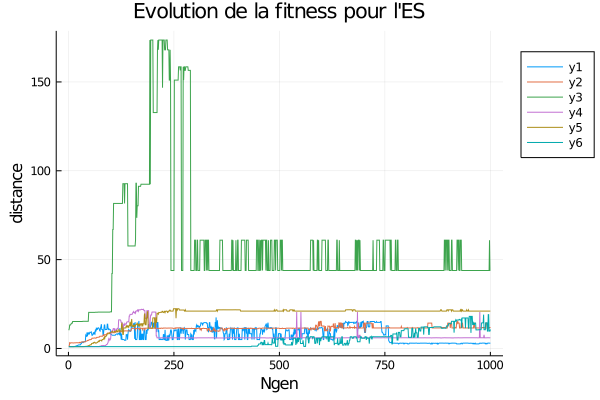

In [111]:
objective = evaluate_bird
Npop = 200
Ngen = 1000
sigma = 0.1
mu = 5

distances = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sigma, mu=mu )
plot(distances,legend=:outertopright)
xaxis!("Ngen")
yaxis!("distance")
title!("Evolution de la fitness pour l'ES")
max distances = 
for i in 1:5
    res = run_es_bird(Nstep=Ngen, Npop=Npop, Sigma=sigma, mu=mu )
    distances = res
    plot!(distances)
end

current()

In [ ]:





#_____________________________CMA_ES_____________________________________





In [50]:
mutable struct CMAES
    N::Int
    μ::Int
    λ::Int
    τ::Float64
    τ_c::Float64
    τ_σ::Float64
    population::Array{Array{Float64}}
    offspring::Array{Array{Float64}}
    F_μ::Array{Float64}
    F_λ::Array{Float64}
    C::Array{Float64}
    s::Array{Float64}
    s_σ::Array{Float64}
    σ::Float64
    E::Array{Float64}
    W::Array{Float64}
    x::Array{Float64}
end

In [51]:
function CMAES(;N=N_value, μ=mu, λ=lambda, τ=sqrt(N), τ_c=N^2, τ_σ=sqrt(N))
    x = randn(N)
    population = fill(x, µ)
    offspring = Array{Array{Float64}}(undef, λ)
    F_µ = Inf .* ones(µ)
    F_λ = Inf .* ones(λ)
    C = Array(Diagonal{Float64}(I, N))
    s = zeros(N)
    s_σ = zeros(N)
    σ = 1.0
    E = zeros(N, λ)
    W = zeros(N, λ);
    CMAES(N, μ, λ, τ, τ_c, τ_σ, population, offspring, F_µ, F_λ, C, s, s_σ, σ, E, W, x)
end

CMAES

In [124]:
function step_cmaes!(c::CMAES; obj=objective)
    # L1
    sqrt_c = cholesky((c.C + c.C') / 2.0).U
    for i in 1:c.λ
        c.E[:,i] = randn(c.N)
        c.W[:,i] = c.σ * (sqrt_c * c.E[:,i])
        c.offspring[i] = c.x + c.W[:,i]
        c.F_λ[i] =  obj(c.offspring[i])
    end    
    # Select new parent population
    idx = sortperm(c.F_λ)[1:c.μ]
    for i in 1:c.μ
        c.population[i] = c.offspring[idx[i]]
        c.F_μ[i] = c.F_λ[idx[i]]
    end    
    # L2
    w = vec(mean(c.W[:,idx], dims=2))##################################################
    c.x += w
    # L3
    c.s = (1.0 - 1.0/c.τ)*c.s + (sqrt(c.μ/c.τ * (2.0 - 1.0/c.τ))/c.σ)*w   
    # L4
    c.C = (1.0 - 1.0/c.τ_c).*c.C + (c.s./c.τ_c)*c.s'    
    # L5
    ɛ = vec(mean(c.E[:,idx], dims=2))##################################################
    c.s_σ = (1.0 - 1.0/c.τ_σ)*c.s_σ + sqrt(c.μ/c.τ_σ*(2.0 - 1.0/c.τ_σ))*ɛ    
    # L6
    c.σ = c.σ*exp(((c.s_σ'*c.s_σ)[1] - c.N)/(2*c.N*sqrt(c.N)))
    
    if c.σ>1.0
        c.σ = 1.0
    end
    #if c.σ<0.0005
    #    c.σ = 0.0005
    #end
    
    c
end

step_cmaes! (generic function with 1 method)

In [125]:
function objective_cma(g::Array{Float64})
    -1*evaluate_bird(g)
end

N_value = 5
mu = 5
lambda = 10
c = CMAES()
println(c.population[1])
println(evaluate_bird(c.population[1]))
step_cmaes!(c, obj=objective_cma)
println(c.population[1])
println(evaluate_bird(c.population[1]))
step_cmaes!(c, obj=objective_cma)
println(c.population[1])
println(evaluate_bird(c.population[1]))
step_cmaes!(c, obj=objective_cma)
println(c.population[1])
println(evaluate_bird(c.population[1]))

[0.9550524119637221, 0.14954986794621175, -0.580022810800907, -0.5751381570158502, 0.8806685489373677]
1.0522265443275203
[1.3204457671773882, -1.0464794721989017, 0.03142775355513916, -1.8744156618616787, -0.5174593447056376]
2.7268857443275203
[0.8901605126360144, -1.7189211991117717, 1.0102264057098065, -1.5997887924746026, 0.04016080098021868]
17.380789955336017
[0.8496554853597497, -0.020851134289247675, 0.13678346924423987, -1.539792763067514, -0.23213843159684633]
6.966236144327522


In [5]:
function run_cmaes(;Nstep=500, mu=5, lambda=10)
    c = CMAES()
    sigs = zeros(Nstep)
    dist = zeros(Nstep)
    for i in 1:Nstep
        step_cmaes!(c,obj=objective_cma)
        sigs[i] = c.σ
        dist[i] = evaluate_bird(c.x)
    end
    [c.x, sigs, dist]
end
    

run_cmaes (generic function with 1 method)

Bird([-3.6900947562290134, -0.4028327734726142, -0.04176554659017216, -1.8375731004129021, -0.0013097813485704348], 332.3009971766702)


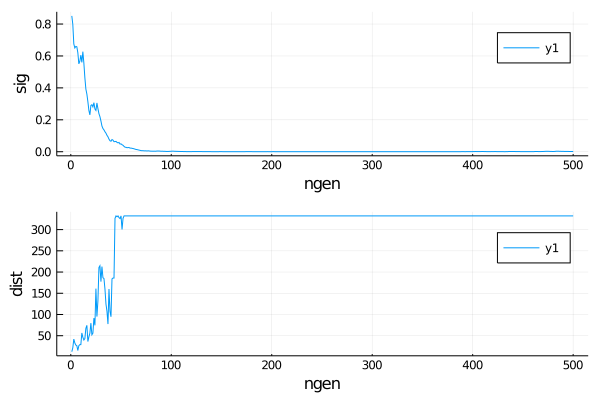

In [246]:
Nstep = 500
mu = 1
lambda = 50

flappy_boss = Bird()
res = run_cmaes(Nstep=Nstep, mu=mu, lambda=lambda)
flappy_boss.genes = res[1]
evaluate!(flappy_boss)
println(flappy_boss)

sigs = res[2]
p1 = plot(sigs)
xaxis!("ngen")
yaxis!("sig")

dist = res[3]
p2 = plot(dist)
xaxis!("ngen")
yaxis!("dist")

plot(p1, p2, layout=(2,1))

#Bird([-4.991793690362872, -1.0548510731723693, -0.46613776158659587, -2.281903602732939, -0.0011843804167953435], 332.30109957667014)

Bird[Bird([-15.191066627346242, -4.340143791602087, -3.1410138447063574, -4.807422988147851, -0.0007543823487974866], 266.32872549484193), Bird([-2.7630263141095552, -0.36725636647340426, 0.4745489817443048, -1.7729002299619736, -0.0038741152772750636], 185.96625957150133), Bird([-2.892028313456245, -0.5982647479709933, 0.6117385898475763, -1.7946282607025976, -0.0027584282179520486], 185.96631077150133), Bird([-6.151445215397052, -1.2054373026939227, -1.1073524847994853, -2.5536112591001117, -0.002079918263160124], 333.3974439773476), Bird([-5.647610358337427, -1.1694676939832014, -0.9300433445092087, -2.3734932616741964, -0.0006436786654238377], 333.3974439773476), Bird([-7.209416138807106, -2.2032359755187794, -0.6900209131619818, -3.4354643266493046, -0.0016952724447234974], 266.3289807832409), Bird([-4.0715383116122785, -0.5625496207271734, -0.27017891790262677, -2.1781103432741813, -0.002558595066680288], 332.3009971766702), Bird([-5.139841356618603, -1.981546808309948, 1.1377459

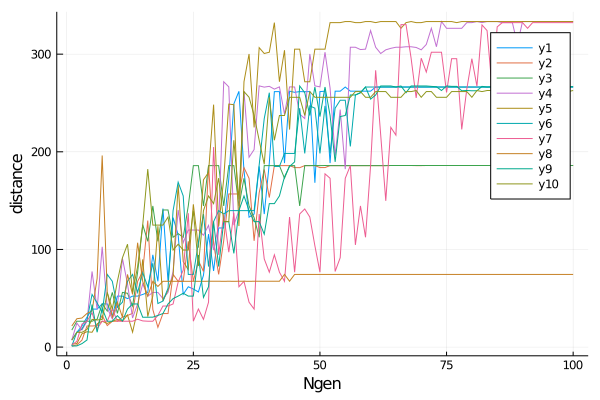

In [252]:
Nrun=10
Nstep = 100
mu=1
lambda= 50

distances = zeros(Nstep, Nrun)
birds = Array{Bird}(undef, Nrun)
for i in 1:Nrun
    res = run_cmaes(Nstep=Nstep, mu=mu, lambda=lambda)
    distances[:,i] = res[3]
    birds[i] = Bird()
    birds[i].genes = res[1]
    evaluate!(birds[i])
end

println(birds)
plot(distances)
xaxis!("Ngen")
yaxis!("distance")

In [ ]:
#_________SANDBOX_____________________

In [ ]:
pop = Array{Bird}(undef, 5)

for i in eachindex(pop)
    pop[i] = Bird()
    evaluate!(pop[i])
end
println(pop)

pop2 = sort(pop, rev=true)

In [225]:
N = ones(3,2)
println(N)
S = [5,10]
#println(N.*S)
#println(S.*N)
#println(dot(S,N))
#println(dot(N,S))
#res1 = [dot(N[:, i]) for i in 1:size(N, 2)]
#println("res1 ",res1)

res2 = reshape([N[i,:].*S for i in 1:3],3,2)
println("res2 ",res2)

x = [2.0,4.0]
P = repeat(x,1,3)
println(P')

println(P'.+N)
println(P'.+res2)

[1.0 1.0; 1.0 1.0; 1.0 1.0]


DimensionMismatch: DimensionMismatch("new dimensions (3, 2) must be consistent with array size 3")

In [67]:
function histogram_birds(method::Function, thresholds::Array{Int}, nTests::Int)
    list_res = zeros(nTests)
    max_found = 0
    for i in 1:nTests
        println("Test n.",i," started ...")
        res = method()
        list_res[i] = res
        if res>max_found
            max_found=res
        end
    end
    println("Plotting ... max found = ", max_found)
    arr = zeros(length(thresholds)+2)
    arr[1] = 0
    for k in 1:length(thresholds)
        arr[k+1]=thresholds[k]
    end
    arr[length(thresholds)+2] = max_found+1
    histogram(list_res, bins=arr)
end

histogram_birds (generic function with 3 methods)

In [68]:
function histogram_birds()
    histogram_birds(method, thresholds, nTests)
end

histogram_birds (generic function with 3 methods)

In [16]:
function random_unif(limit::Float64)
    rand()*limit
end

function random_unif()
    random_unif(500.0)
end

random_unif (generic function with 2 methods)

Test n.1 started ...
Test n.2 started ...
Test n.3 started ...
Test n.4 started ...
Test n.5 started ...
Test n.6 started ...
Test n.7 started ...
Test n.8 started ...
Test n.9 started ...
Test n.10 started ...
Test n.11 started ...
Test n.12 started ...
Test n.13 started ...
Test n.14 started ...
Test n.15 started ...
Test n.16 started ...
Test n.17 started ...
Test n.18 started ...
Test n.19 started ...
Test n.20 started ...
Plotting ... max found = 412.7902937897372


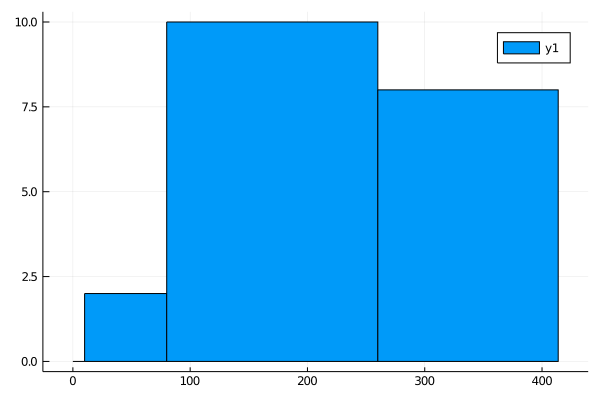

In [72]:
method = random_unif # l'algo doit renvoyer la distance en fin d'évolution
thresholds = [10, 80, 260] # les délimitations des cases où ranger les résultats
nTests = 20 # nombre de tests à effectuer

histogram_birds()